In [74]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torch import nn
import numpy as np
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from functions import MyLSTM, black_process, white_process

# Importing the data

In [75]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    if '' in ls:
        print(f"WHAT THE FUCK : {str}")
    list = [float(i) for i in ls]
    return list

In [76]:
df = pd.read_csv('lichess_db_standard_rated_2023-08_1_1000000.csv', dtype  ={'Eval':'string'})

In [77]:
# filtering out None or empty evaluations
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]
df = df[~df['Eval'].str.contains('None')]
df = df[df['Eval']!='']
df = df[df['Eval'] != '']
df = df[df['Eval'] != '[]']

In [78]:
df.value_counts('TimeControl')

TimeControl
600+0       15404
180+0       14146
60+0        11808
300+0       10071
180+2        9539
            ...  
1080+9          1
720+2           1
7200+120        1
7200+45         1
420+4           1
Name: count, Length: 295, dtype: int64

In [79]:
# picking a time control - I'm looking at 3 minute games
df = df[df["Clock"] != '[]']
df = df[~df["Clock"].str.contains(',,')]

In [80]:
# defining a function to return initial time and increment
def get_init_time(string):
    t = string.split('+')
    return int(t[0])

def get_inc(string):
    t = string.split('+')
    return int(t[1])

In [81]:
# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

# converting the evaluations and clock times to lists
df['Eval'] = df['Eval'].apply( to_list)
df['Clock'] = df['Clock'].apply(to_list)

df['Increment'] = df["TimeControl"].apply(get_inc)
df['Init_time'] = df["TimeControl"].apply(get_init_time)

# processing the evaluations and clock times into feature sequences
df['WhiteEval'] =df.apply(lambda x : white_process(x.Eval, x.Clock, x.Init_time, x.Init_time, x.Increment, x.BlackELO), axis =1 )
df['BlackEval'] = df.apply(lambda x : black_process(x.Eval, x.Clock,x.Init_time,x.Init_time,x.Increment,x.WhiteELO), axis =1 )

In [82]:
df['Clock'].head()

0    [300.0, 300.0, 299.0, 299.0, 298.0, 297.0, 297...
1    [300.0, 300.0, 295.0, 301.0, 293.0, 303.0, 292...
2    [300.0, 300.0, 299.0, 289.0, 276.0, 286.0, 273...
3    [180.0, 180.0, 181.0, 182.0, 183.0, 183.0, 184...
4    [60.0, 60.0, 60.0, 59.0, 59.0, 59.0, 59.0, 58....
Name: Clock, dtype: object

In [83]:
df.Eval

0        [0.0, 27.0, 29.0, 30.0, 16.0, 94.0, -74.0, 64....
1        [0.0, 27.0, 29.0, 30.0, 16.0, 27.0, 15.0, 21.0...
2        [0.0, 98.0, 80.0, 159.0, 23.0, 47.0, 19.0, 942...
3        [0.0, 90.0, 34.0, 30.0, 50.0, 126.0, 98.0, 117...
4        [0.0, 27.0, 13.0, 51.0, 2.0, 35.0, 3.0, 66.0, ...
                               ...                        
86989    [36.0, 32.0, 0.0, 0.0, 14.0, 39.0, 25.0, 45.0,...
86990    [36.0, 35.0, 29.0, 32.0, 21.0, 20.0, 25.0, 152...
86991    [36.0, 35.0, 29.0, 32.0, 21.0, 76.0, 56.0, 98....
86992    [36.0, 32.0, 0.0, 15.0, 0.0, 11.0, 0.0, 0.0, 0...
86993    [0.0, 27.0, 0.0, 6.0, 9.0, 58.0, 39.0, 52.0, 2...
Name: Eval, Length: 86764, dtype: object

In [84]:
df['WhiteEval'].head()

0    [[99.9999, 0.0, 300.0, 0.0, 1898.0], [100.8279...
1    [[99.9999, 0.0, 300.0, 3.0, 1554.0], [100.8279...
2    [[99.9999, 0.0, 300.0, 3.0, 1282.0], [93.00264...
3    [[99.9999, 0.0, 180.0, 2.0, 1835.0], [79.51409...
4    [[99.9999, 0.0, 60.0, 0.0, 1490.0], [94.378213...
Name: WhiteEval, dtype: object

In [85]:
df['BlackEval'].head()

0    [[89.42685016134062, 0.0, 300.0, 0.0, 1820.0],...
1    [[89.42685016134062, 0.0, 300.0, 3.0, 1606.0],...
2    [[66.78275170056337, 0.0, 300.0, 3.0, 1176.0],...
3    [[68.99392747162456, 0.0, 180.0, 2.0, 1828.0],...
4    [[89.42685016134062, 0.0, 60.0, 0.0, 1500.0], ...
Name: BlackEval, dtype: object

In [86]:
#copying black's evaluations to the same column as white's, so we examine each game from both perspectives
# NOTE: I'm filtering out some elos between 1200 and  2200 to try to get a larger range of predictions 
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
t = df_flipped['WhiteELO'].astype(float)
df_flipped['WhiteELO'] = df_flipped['BlackELO'].astype(float)
df_flipped['BlackELO'] = t
df_flipped['White'] = df_flipped['Black']
#df_flipped = df_flipped[ (df_flipped['WhiteELO'] <1200) | (df_flipped['WhiteELO'] >2200)]
df = pd.concat([df, df_flipped])

In [87]:
# Another idea is to predict the elo difference?

In [88]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 173528


# Regularizing Data

In [89]:
white_x = numpy.array(df['WhiteEval'])
white_length = numpy.array(df['WhiteEval'].apply(len))

black_x = numpy.array(df['WhiteEval'])
black_length = numpy.array(df['WhiteEval'].apply(len))

In [90]:
white_x

array([array([[9.99999000e+01, 0.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [1.00827985e+02, 1.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [9.43806011e+01, 1.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [4.97408830e+01, 1.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [9.87829569e+01, 5.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [9.18060571e+01, 3.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [7.13070556e+01, 3.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [9.40056011e+01, 1.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
              [9.55879056e+01, 2.00000000e+00, 3.00000000e+02, 0.00000000e+00,
               1.89800000e+03],
 

In [91]:
# creating and fitting a power transformer for black and white
wpt = StandardScaler()

white_y = numpy.concatenate(white_x) # concatenating so that the data has shape (samples,features)


In [92]:
white_y

array([[9.99999000e+01, 0.00000000e+00, 3.00000000e+02, 0.00000000e+00,
        1.89800000e+03],
       [1.00827985e+02, 1.00000000e+00, 3.00000000e+02, 0.00000000e+00,
        1.89800000e+03],
       [9.43806011e+01, 1.00000000e+00, 3.00000000e+02, 0.00000000e+00,
        1.89800000e+03],
       ...,
       [1.11907164e+02, 1.00000000e+00, 1.80000000e+02, 2.00000000e+00,
        8.89000000e+02],
       [1.00039868e+02, 1.00000000e+00, 1.80000000e+02, 2.00000000e+00,
        8.89000000e+02],
       [1.00039728e+02, 2.00000000e+00, 1.80000000e+02, 2.00000000e+00,
        8.89000000e+02]])

In [93]:
wpt.fit(white_y)
white_transformed = wpt.transform(white_y)

In [94]:
bpt = PowerTransformer()
black_y = numpy.concatenate(black_x)
bpt.fit(black_y)
black_transformed = bpt.transform(black_y)

In [95]:
from joblib import dump
dump(wpt, 'w_eval_scaler.bin', compress=True)
dump(bpt, 'b_eval_scaler.bin', compress=True)

['b_eval_scaler.bin']

<Axes: >

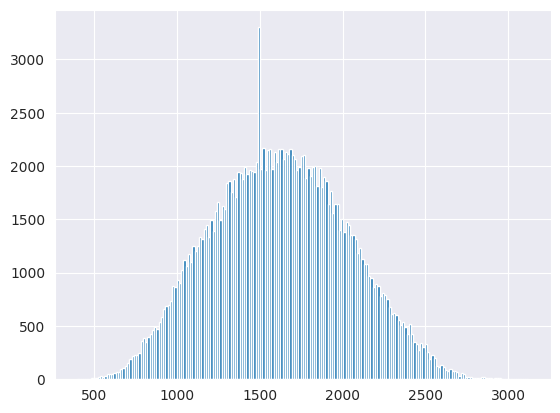

In [96]:
df['WhiteELO'].hist(bins = 200)

In [97]:
df['Target'] = df['WhiteELO'] - df['BlackELO']

In [98]:
target_arr = numpy.array(df['Target'])

In [99]:
#welopt = PowerTransformer(method = 'box-cox')
welopt = StandardScaler()
target_arr = np.reshape(target_arr, (len(target_arr),1))
welopt.fit(target_arr)
target_transformed = welopt.transform(target_arr)

(array([4.0000e+00, 1.0000e+01, 2.3000e+01, 7.5000e+01, 1.3500e+02,
        3.3900e+02, 8.8900e+02, 2.6280e+03, 4.1390e+03, 7.7458e+04,
        7.9535e+04, 4.1630e+03, 2.6450e+03, 8.9800e+02, 3.3900e+02,
        1.3500e+02, 7.6000e+01, 2.3000e+01, 1.0000e+01, 4.0000e+00]),
 array([-11.93214413, -10.73892972,  -9.5457153 ,  -8.35250089,
         -7.15928648,  -5.96607207,  -4.77285765,  -3.57964324,
         -2.38642883,  -1.19321441,   0.        ,   1.19321441,
          2.38642883,   3.57964324,   4.77285765,   5.96607207,
          7.15928648,   8.35250089,   9.5457153 ,  10.73892972,
         11.93214413]),
 <BarContainer object of 20 artists>)

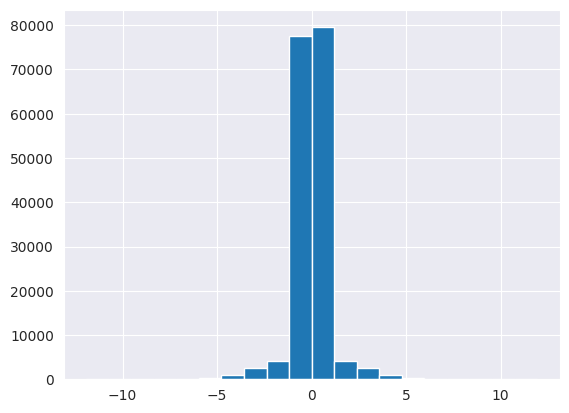

In [100]:
plt.hist(target_transformed, bins =20)

In [101]:
white_transformed_array = [numpy.array(list(islice(iter(white_transformed), elem)))
        for elem in white_length]

black_transformed_array = [numpy.array(list(islice(iter(black_transformed), elem)))
        for elem in black_length]

# Splitting data into a training and test set

In [102]:
white_transformed_array[100]

array([[ 0.5600182 , -0.4241114 , -0.1487679 , -0.38318537,  0.59164883],
       [ 0.59996911, -0.34396071, -0.1487679 , -0.38318537,  0.59164883],
       [ 0.28891531, -0.34396071, -0.1487679 , -0.38318537,  0.59164883],
       [-1.86472637, -0.34396071, -0.1487679 , -0.38318537,  0.59164883],
       [ 0.50130681, -0.02335794, -0.1487679 , -0.38318537,  0.59164883],
       [ 0.16470652, -0.18365932, -0.1487679 , -0.38318537,  0.59164883],
       [-0.82426711, -0.18365932, -0.1487679 , -0.38318537,  0.59164883],
       [ 0.27082345, -0.34396071, -0.1487679 , -0.38318537,  0.59164883],
       [ 0.34716168, -0.26381001, -0.1487679 , -0.38318537,  0.59164883],
       [ 0.59442966, -0.18365932, -0.1487679 , -0.38318537,  0.59164883],
       [-2.94574471, -0.34396071, -0.1487679 , -0.38318537,  0.59164883]])

In [103]:
# converting evaluations and length to tensors
white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]
white_lengths = [len(tensor) for tensor in white_evals]

black_evals = [torch.tensor(i, dtype = torch.float32) for i in black_transformed_array]
black_lengths = [len(tensor) for tensor in black_evals]


In [104]:
def avg_cpl(white_processed):
    '''
    return the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [105]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [106]:
# Converting White and Black's ELOs to tensors
white_elo = [torch.tensor(i, dtype = torch.float32) for i in target_transformed]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
white_eval_train, white_eval_test, white_train, white_test, average_cpl_train, average_cpl_test = train_test_split(white_evals,white_elo, average_cpl, test_size=0.2,random_state=0, shuffle = True)

In [107]:
# zipping together the features and targets
train_data_zip = list(zip(white_eval_train, white_train))
test_data_zip = list(zip(white_eval_test, white_test))

In [108]:
# black_elo = torch.stack(black_elo)
# white_elo = torch.stack(white_elo)

## Baseline model

In [109]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [110]:
white_train_elo = np.array([x.item() for x in white_train])
white_train_elo = np.reshape(white_train_elo, (len(white_train_elo),1 ))
white_train_elo_transformed = welopt.inverse_transform(white_train_elo)

white_test_elo = np.array([x.item() for x in white_test])
white_test_elo = np.reshape(white_test_elo, (len(white_test_elo),1 ))
white_test_elo_transformed = welopt.inverse_transform(white_test_elo)

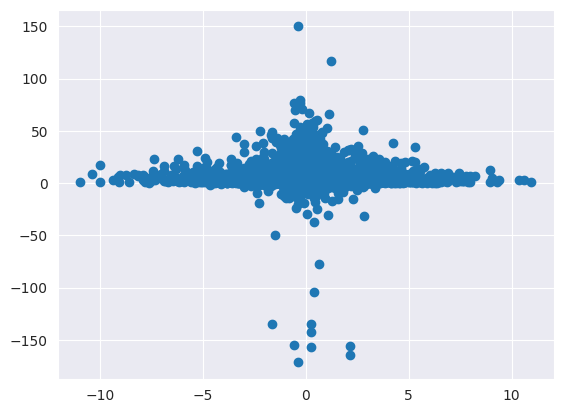

In [111]:
plt.scatter(white_test_elo,average_cpl_test)

In [112]:
# make a simple linear regression model.
regression = LinearRegression()
regression.fit(average_cpl_train,white_train_elo_transformed)
regression.score(average_cpl_test,white_test_elo)
y_pred = regression.predict(average_cpl_test)

In [113]:
mse_lin = mean_squared_error(white_test_elo_transformed, y_pred)

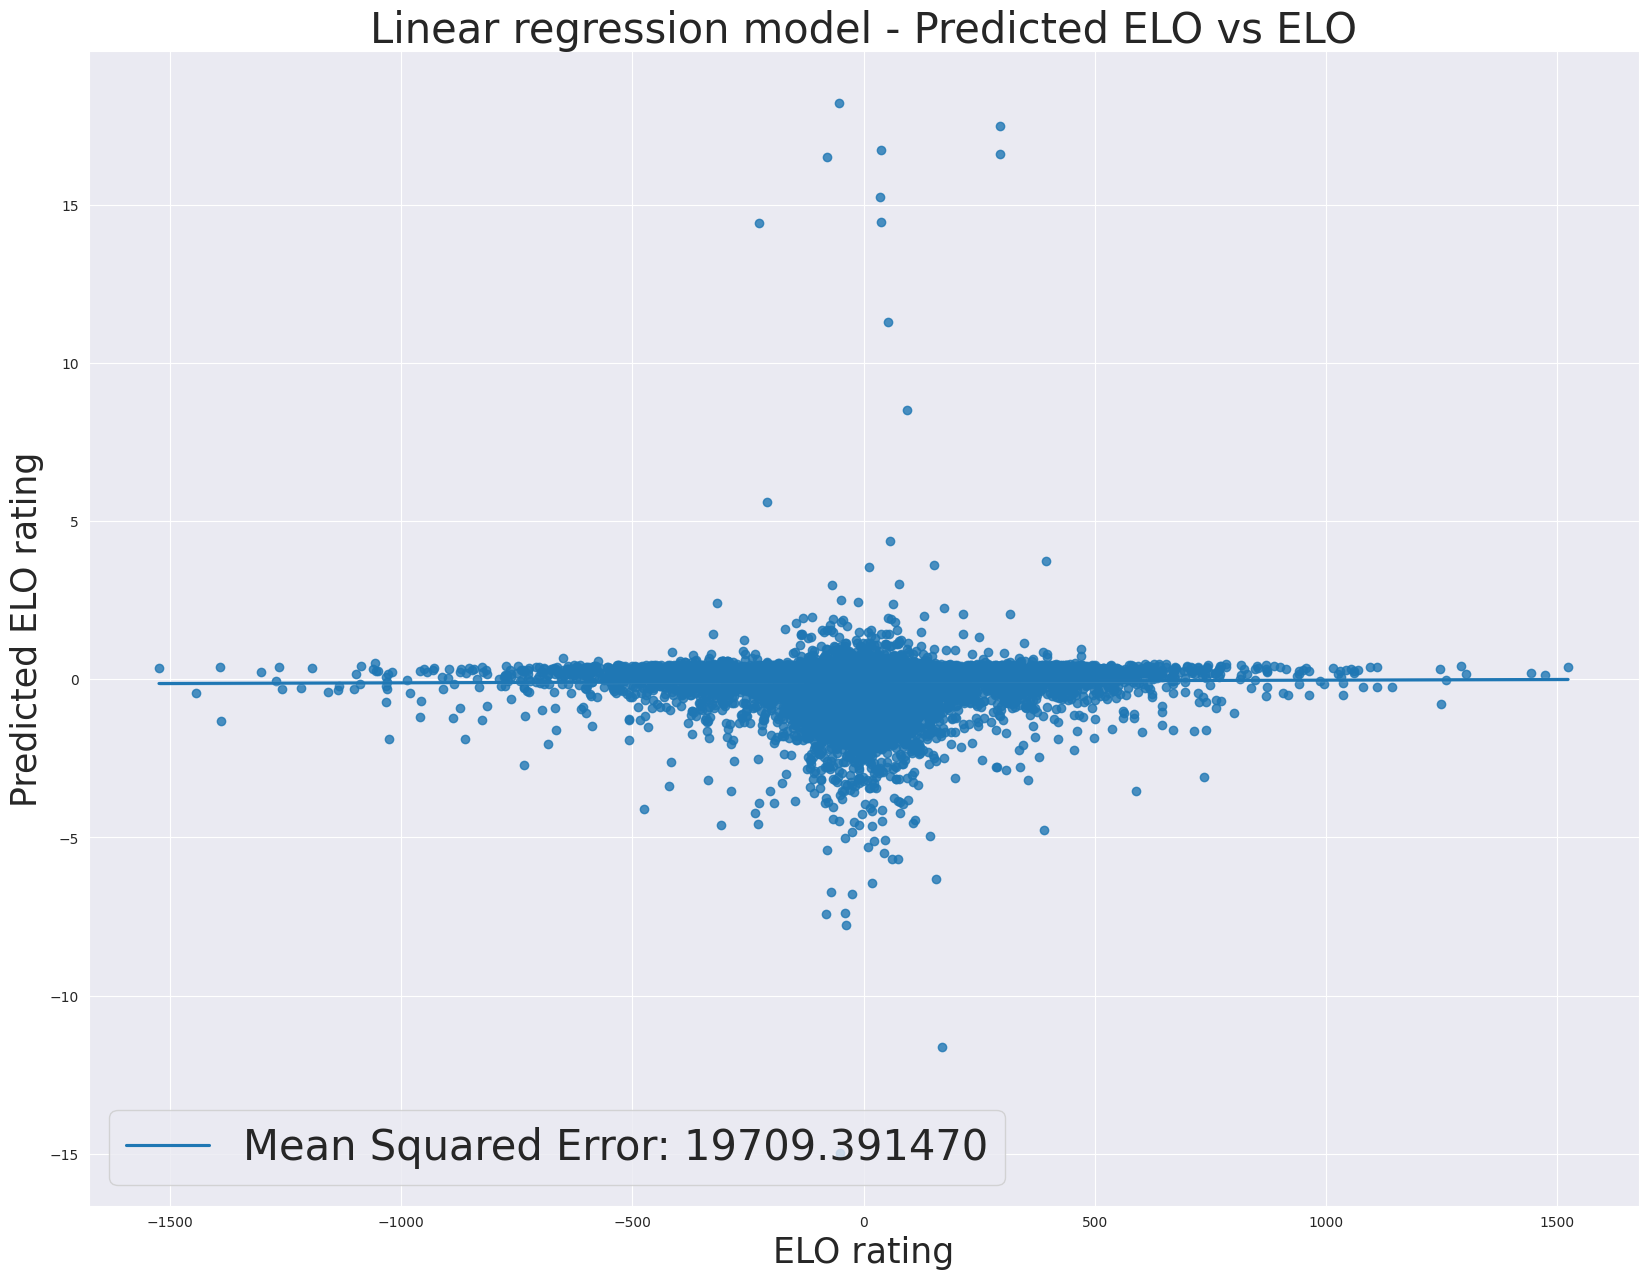

In [114]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = white_test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})

# Creating the Neural Network

In [115]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        #print(f"FIRST WD COLL: {white_data[7]}")
        target = [item[1] for item in batch]
        #print(f"TARGET: {target[7]}")
        white_lens = [i.shape[0] for i in white_data]
        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        #print("WHite data 2 shape",(white_data).size())
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)
        target = torch.tensor(target,dtype=torch.float32)
        return [white_evals_packed, target]

In [116]:
# defining parameters for the neural net
input_size = 5
hidden_size = 16
no_layers = 2


In [117]:
model = MyLSTM(input_size, hidden_size, no_layers)
#model.load_state_dict(torch.load('networks/main_model_epoch_3.pt'))
collate = MyCollator()
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): RNN(5, 16, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (end): Linear(in_features=32, out_features=1, bias=True)
  (final): LeakyReLU(negative_slope=0.01)
)>


# Training the model

In [118]:
# defining loss functions
@torch.compile(mode = 'max-autotune')
def custom_loss(outputs, elo):
    criterion = nn.MSELoss()
    l = criterion(outputs,elo)
    var = ((outputs - outputs.mean())**2).mean()
    elo_var = ((elo - elo.mean())**2).mean()
    z = (var-elo_var)**2
    
    # trying to match minima and maxima
    mindiff = (outputs.min() - elo.min())**2
    maxdiff = (outputs.max() - elo.max())**2
    return l+z+mindiff+maxdiff

In [119]:
writer = SummaryWriter('runs/h45l4-2')

In [120]:
learning_rate = .0001

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [122]:
criterion = nn.MSELoss()
criterion = custom_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [123]:
batch_size = 512

In [124]:
import torch.nn.utils as utils


Epoch 1 step 273 - Learning Rate : 0.0001- Avg Loss: 83.306623 - Change in loss: 833.0662284177891


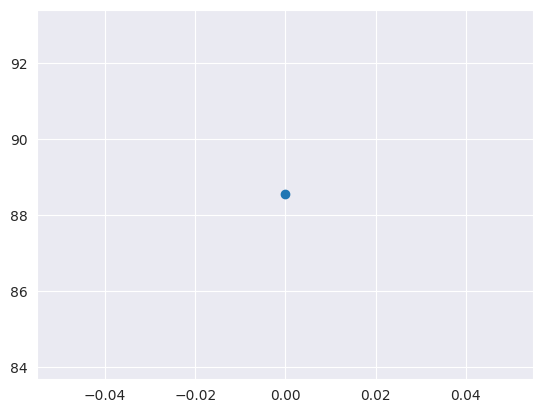

Epoch 2 step 273 - Learning Rate : 0.0001- Avg Loss: 84.302492 - Change in loss: 1.0119542613984638


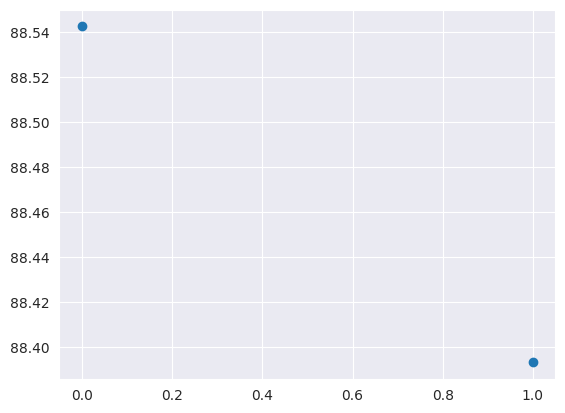

Epoch 3 step 273 - Learning Rate : 0.0001- Avg Loss: 81.692132 - Change in loss: 0.969035789964288


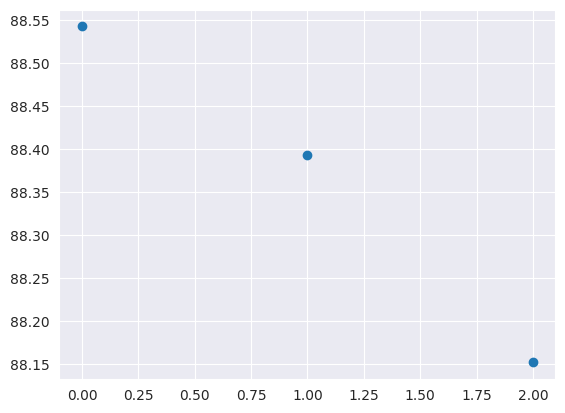

Epoch 4 step 273 - Learning Rate : 0.0001- Avg Loss: 82.838722 - Change in loss: 1.0140354994603982


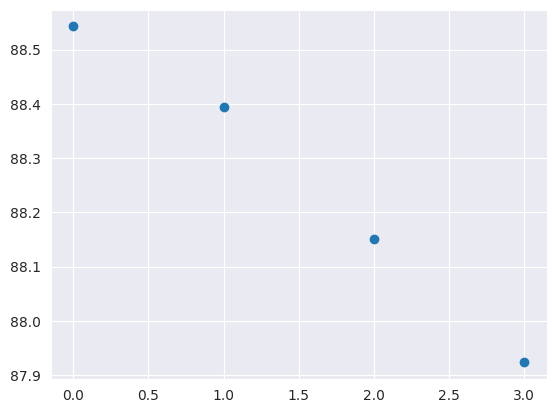

Epoch 5 step 273 - Learning Rate : 0.0001- Avg Loss: 83.044492 - Change in loss: 1.0024839819687645


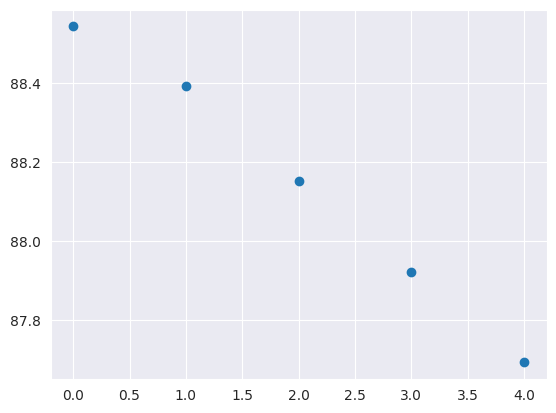

Epoch 6 step 273 - Learning Rate : 0.0001- Avg Loss: 83.424814 - Change in loss: 1.0045797436614763


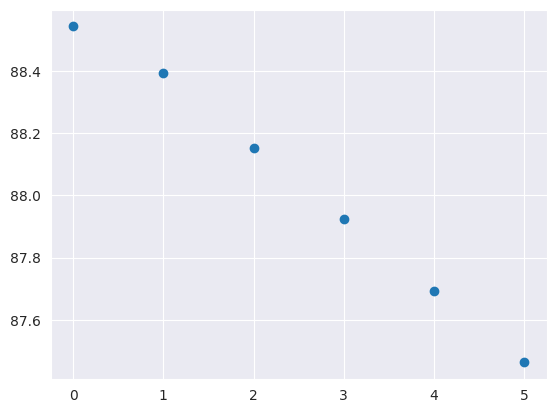

Epoch 7 step 273 - Learning Rate : 0.0001- Avg Loss: 82.313062 - Change in loss: 0.9866736035732742


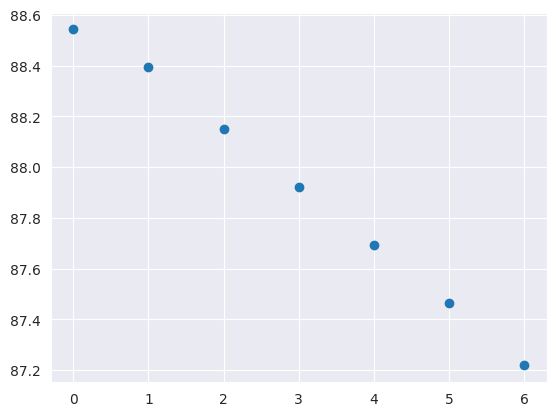

Epoch 8 step 273 - Learning Rate : 0.0001- Avg Loss: 82.993028 - Change in loss: 1.0082607290516012


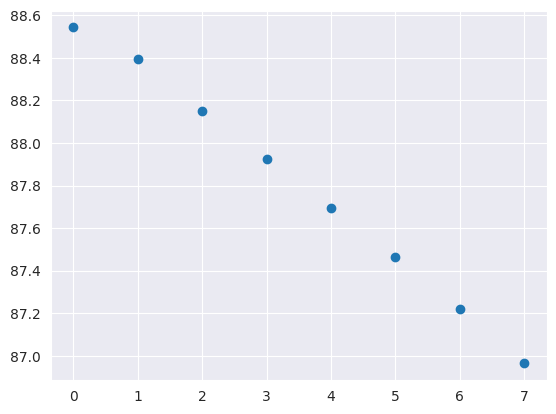

Epoch 9 step 273 - Learning Rate : 0.0001- Avg Loss: 82.267136 - Change in loss: 0.9912535836534911


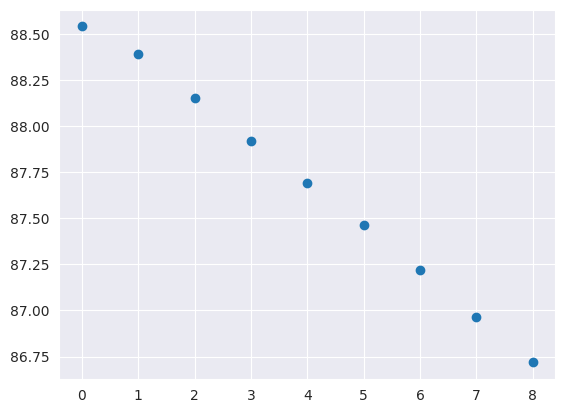

Epoch 10 step 273 - Learning Rate : 0.0001- Avg Loss: 80.589262 - Change in loss: 0.979604563208311


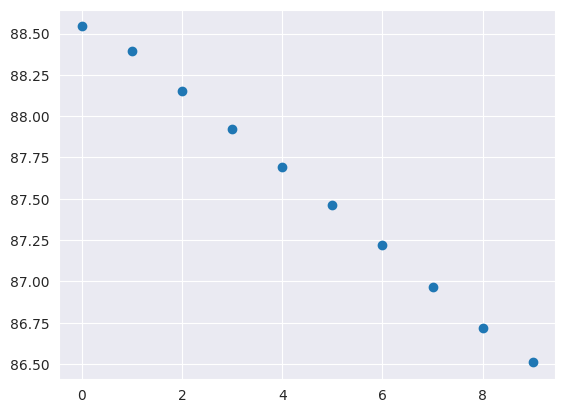

Epoch 11 step 273 - Learning Rate : 0.0001- Avg Loss: 82.159123 - Change in loss: 1.0194797718961468


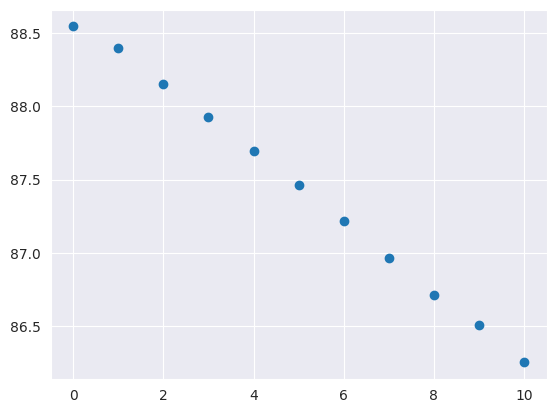

Epoch 12 step 273 - Learning Rate : 0.0001- Avg Loss: 81.773255 - Change in loss: 0.9953034053764405


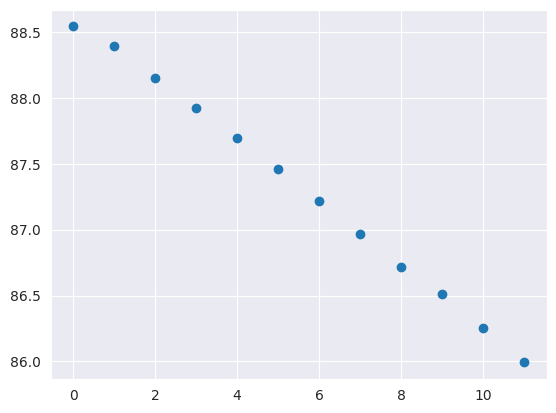

Epoch 13 step 273 - Learning Rate : 0.0001- Avg Loss: 81.986750 - Change in loss: 1.0026108233338107


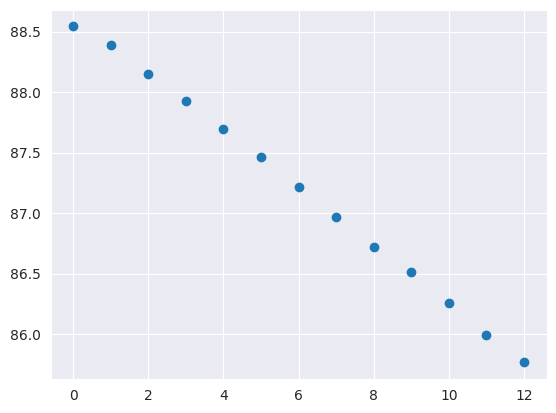

Epoch 14 step 273 - Learning Rate : 0.0001- Avg Loss: 80.703474 - Change in loss: 0.9843477593649286


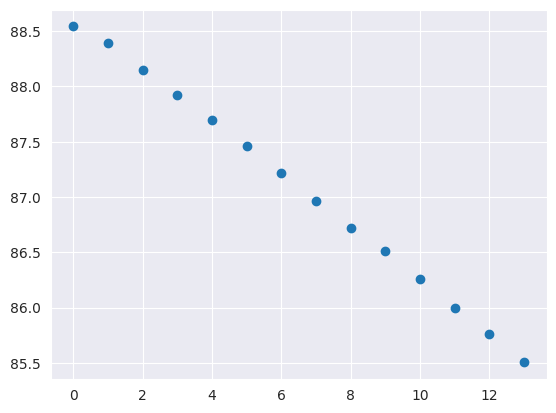

Epoch 15 step 273 - Learning Rate : 0.0001- Avg Loss: 79.789955 - Change in loss: 0.9886805541917533


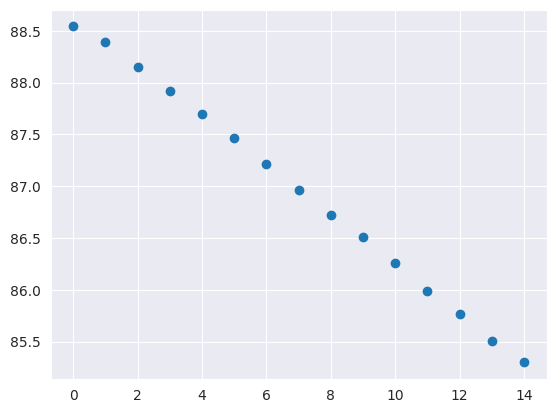

Epoch 16 step 273 - Learning Rate : 0.0001- Avg Loss: 79.980964 - Change in loss: 1.0023938952648985


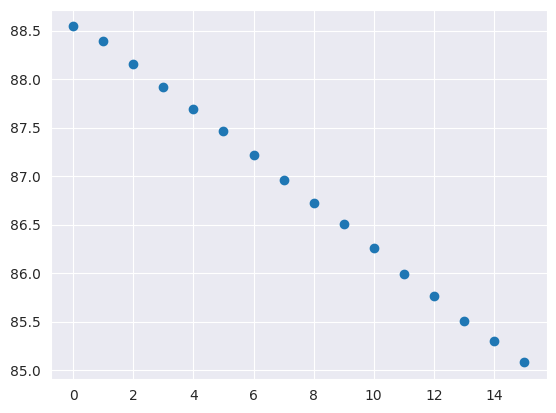

Epoch 17 step 273 - Learning Rate : 0.0001- Avg Loss: 81.002894 - Change in loss: 1.0127771639880536


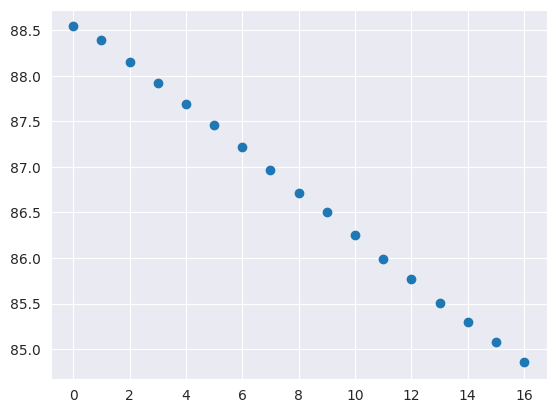

Epoch 18 step 273 - Learning Rate : 0.0001- Avg Loss: 79.460550 - Change in loss: 0.980959401544566


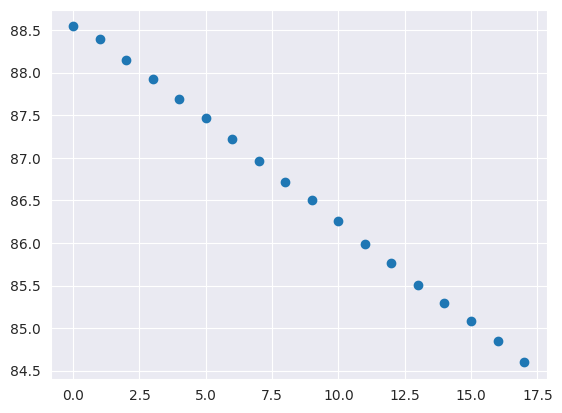

Epoch 19 step 273 - Learning Rate : 0.0001- Avg Loss: 80.736115 - Change in loss: 1.0160528041845598


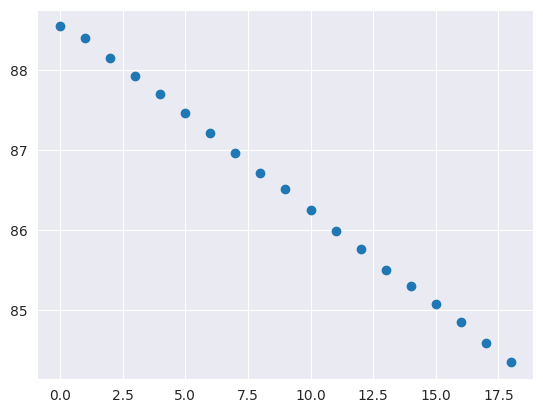

Epoch 20 step 273 - Learning Rate : 0.0001- Avg Loss: 79.699618 - Change in loss: 0.987161922378955


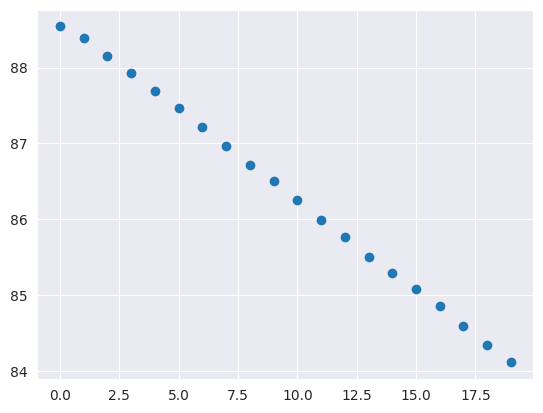

Epoch 21 step 273 - Learning Rate : 0.0001- Avg Loss: 80.029482 - Change in loss: 1.0041388333202483


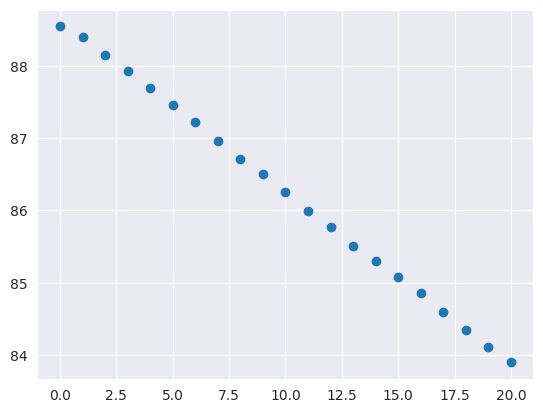

Epoch 22 step 273 - Learning Rate : 0.0001- Avg Loss: 78.957192 - Change in loss: 0.9866013149541047


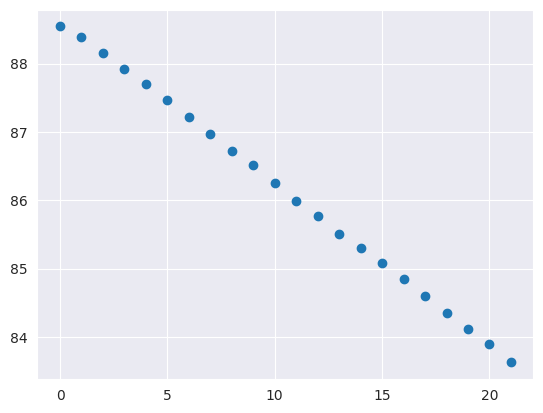

In [ ]:
avg_losses = []
epochs = []
avg_loss = 0.1


test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=batch_size, shuffle=False ,collate_fn=collate)
for epoch in range(1000):
    data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True,collate_fn=collate)
    losses = []
    model.train()
    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        loss = criterion(outputs,elo)

        # optimizing
        optimizer.zero_grad()
        loss.backward()
        #utils.clip_grad_norm_(model.parameters(), 1000)
        for param in model.parameters():
            param.grad = torch.clamp(param.grad, min=0.00001)

        optimizer.step()
        losses.append(loss.item())
        i+=1

    # evaluating on the test data
    model.eval()
    tlosses = []
    for evals, elo in test_data_loader:
        evals = evals.to(device)
        elo = elo.to(device)
        output = model(evals)
        loss = criterion(output,elo)
        tlosses.append(loss.item())

    
    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',stats.mean(tlosses), epoch)
    avg_losses.append(stats.mean(tlosses))
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')
    torch.save(model.state_dict(), f'networks/main_model_epoch_{epoch+1}.pt')
    plt.scatter(epochs, avg_losses)
    plt.show()
writer.close() 

## Evaluating the model

In [ ]:
model.eval()

In [ ]:

model.to(device)

In [ ]:
test_data_loader1 = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [ ]:
# getting a list of outputs for the test data
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader1:
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

In [ ]:
# preparing data to be inverse transformed
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))


In [ ]:
print(outputs.min())

In [ ]:
# getting elos from the normalized values
elos = welopt.inverse_transform(elos)
outputs = welopt.inverse_transform(outputs)

In [ ]:
mse_model = mean_squared_error(elos,outputs)

In [ ]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
#plt.savefig('images/NN_model_acc1.png')

In [ ]:
torch.save(model.state_dict(), 'main_model.pt')

In [ ]:
model.load_state_dict(torch.load('main_model.pt'))

In [ ]:
sns.regplot(elos,outputs)